In [874]:
# Import necessary libraries and packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

# Set floating point precision option for pandas
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Import seaborn library and set context and style
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')

# Import warnings and set filter to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Import time library
from time import time

# Import matplotlib ticker and scipy stats
import matplotlib.ticker as tkr
from scipy import stats

# Import statistical tools for time series analysis
from statsmodels.tsa.stattools import adfuller

# Import preprocessing from sklearn
from sklearn import preprocessing

# Import partial autocorrelation function from statsmodels
from statsmodels.tsa.stattools import pacf

# Enable inline plotting in Jupyter Notebook
%matplotlib inline

# Import math library
import math

# Import necessary functions from keras
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *

# Import MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Import mean squared error and mean absolute error from sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Import early stopping from keras callbacks
from keras.callbacks import EarlyStopping

In [875]:
# Load the data from the file 'household_power_consumption.txt' using pandas
# and specify the delimiter as ';'
data = pd.read_csv('block_0.csv')

# Print the number of rows and columns in the data
print('Number of rows and columns:', data.shape)

# Display the first 5 rows of the data
data.head(5)

Number of rows and columns: (505, 2)


,day,energy_sum
0,10/12/2012,7.0980
1,10/13/2012,11.0870
2,10/14/2012,13.2230
3,10/15/2012,10.2570
4,10/16/2012,9.7690


In [876]:
# Display the last 5 rows of the data
data.tail(5)

,day,energy_sum
500,2/24/2014,12.5280
501,2/25/2014,11.8260
502,2/26/2014,12.3280
503,2/27/2014,20.5180
504,2/28/2014,1.3870


In [877]:
print("\nInformation about the dataframe:")
print(data.info())


Information about the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   day         505 non-null    object 
 1   energy_sum  505 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.0+ KB
None


In [878]:
print("\nData type of each column in the dataframe:")
print(data.dtypes)


Data type of each column in the dataframe:
day            object
energy_sum    float64
dtype: object


In [879]:
#Feature Engineering

data['date_time'] = pd.to_datetime(data['day'])

# Convert the 'Global_active_power' column to numeric format
# and remove any rows with NaN values
data['energy_sum'] = pd.to_numeric(data['energy_sum'], errors='coerce')
data = data.dropna(subset=['energy_sum'])

# Create new columns for year, quarter, month, and day
data['year'] = data['date_time'].apply(lambda x: x.year)
data['quarter'] = data['date_time'].apply(lambda x: x.quarter)
data['month'] = data['date_time'].apply(lambda x: x.month)
data['day'] = data['date_time'].apply(lambda x: x.day)

# Keep only the columns 'date_time', 'Global_active_power', 'year', 'quarter', 'month', 'day'
data = data.loc[:,['date_time','energy_sum', 'year','quarter','month','day']]

# Sort the data by date_time in ascending order
data.sort_values('date_time', inplace=True, ascending=True)

# Reset the index of the data
data = data.reset_index(drop=True)

# Create a new column 'weekday' that indicates if the day is a weekday (1) or weekend (0)
data['weekday'] = data['date_time'].apply(lambda x: x.weekday() < 5).astype(int)



In [880]:
# Print the number of rows and columns in the data
print('Number of rows and columns:', data.shape)

# Print the minimum and maximum date_time values
print('Minimum date_time:', data.date_time.min())
print('Maximum date_time:', data.date_time.max())

# Display the last 5 rows of the data
data.tail(5)

Number of rows and columns: (505, 7)
Minimum date_time: 2012-10-12 00:00:00
Maximum date_time: 2014-02-28 00:00:00


,date_time,energy_sum,year,quarter,month,day,weekday
500,2014-02-24,12.5280,2014,1,2,24,1
501,2014-02-25,11.8260,2014,1,2,25,1
502,2014-02-26,12.3280,2014,1,2,26,1
503,2014-02-27,20.5180,2014,1,2,27,1
504,2014-02-28,1.3870,2014,1,2,28,1


In [881]:
# Display the last 5 rows of the data
data.head(10)

,date_time,energy_sum,year,quarter,month,day,weekday
0,2012-10-12,7.0980,2012,4,10,12,1
1,2012-10-13,11.0870,2012,4,10,13,0
2,2012-10-14,13.2230,2012,4,10,14,0
3,2012-10-15,10.2570,2012,4,10,15,1
4,2012-10-16,9.7690,2012,4,10,16,1
5,2012-10-17,10.8850,2012,4,10,17,1
6,2012-10-18,10.7510,2012,4,10,18,1
7,2012-10-19,8.4310,2012,4,10,19,1
8,2012-10-20,17.3780,2012,4,10,20,0
9,2012-10-21,24.4900,2012,4,10,21,0


In [882]:
data.drop_duplicates(subset=['date_time'], keep='first')

,date_time,energy_sum,year,quarter,month,day,weekday
0,2012-10-12,7.0980,2012,4,10,12,1
1,2012-10-13,11.0870,2012,4,10,13,0
2,2012-10-14,13.2230,2012,4,10,14,0
3,2012-10-15,10.2570,2012,4,10,15,1
4,2012-10-16,9.7690,2012,4,10,16,1
...,...,...,...,...,...,...,...
500,2014-02-24,12.5280,2014,1,2,24,1
501,2014-02-25,11.8260,2014,1,2,25,1
502,2014-02-26,12.3280,2014,1,2,26,1
503,2014-02-27,20.5180,2014,1,2,27,1


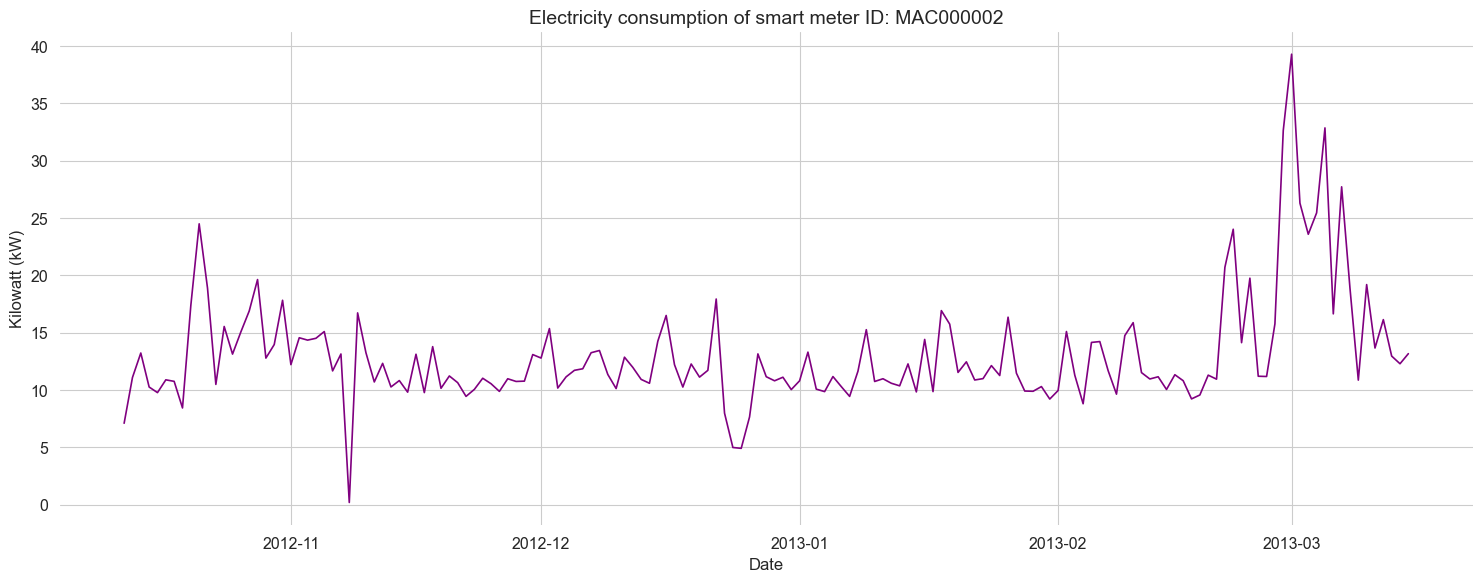

In [883]:
#Exploratory Data Analysis(EDA)

data1 = data[(data.date_time >= '2012-10-12') & (data.date_time < '2013-03-16')]

plt.figure(figsize=(15,6))
plt.plot(data1.date_time, data1.energy_sum, color='purple')
plt.ylabel('Kilowatt (kW)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.title('Electricity consumption of smart meter ID: MAC000002', fontsize=14)
plt.tight_layout()
plt.grid(True)
sns.despine(bottom=True, left=True)
plt.show()

In [884]:
#Transform the Global_active_power column of the data DataFrame into a numpy array of float values

dataset = data.energy_sum.values.astype('float32')
#Reshape the numpy array into a 2D array with 1 column

dataset = np.reshape(dataset, (-1, 1))
#Create an instance of the MinMaxScaler class to scale the values between 0 and 1

scaler = MinMaxScaler(feature_range=(0, 1))
#Fit the MinMaxScaler to the transformed data and transform the values

dataset = scaler.fit_transform(dataset)
#Split the transformed data into a training set (80%) and a test set (20%)

train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [885]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [886]:
# reshape into X=t and Y=t+1
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

X_train.shape

(373, 30)

In [887]:
Y_train.shape

(373,)

In [888]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [889]:
X_train.shape

(373, 1, 30)

In [890]:
# LSTM Model
# Defining the LSTM model
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import SGD

model = Sequential()

# Adding the first layer with 100 LSTM units and input shape of the data
model.add(LSTM(2000, input_shape=(X_train.shape[1], X_train.shape[2])))

# Adding a dropout layer to avoid overfitting
model.add(Dropout(0.9))

# Adding a dense layer with 1 unit to make predictions
model.add(Dense(30, activation='relu', kernel_constraint=MaxNorm(3)))

# Compile model
sgd = SGD(learning_rate=0.1, momentum=0.9)

# Compiling the model with mean squared error as the loss function and using Adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

# Fitting the model on training data and using early stopping to avoid overfitting
history = model.fit(X_train, Y_train, epochs=70, batch_size=100, validation_data=(X_test, Y_test), 
        callbacks=[EarlyStopping(monitor='val_loss', patience=25)], verbose=2, shuffle=False)


Epoch 1/70
4/4 - 44s - loss: 0.0722 - accuracy: 0.0000e+00 - val_loss: 0.0501 - val_accuracy: 0.0000e+00 - 44s/epoch - 11s/step
Epoch 2/70
4/4 - 6s - loss: 0.0248 - accuracy: 0.0000e+00 - val_loss: 0.0138 - val_accuracy: 0.0000e+00 - 6s/epoch - 1s/step
Epoch 3/70
4/4 - 5s - loss: 0.0265 - accuracy: 0.0000e+00 - val_loss: 0.0163 - val_accuracy: 0.0000e+00 - 5s/epoch - 1s/step
Epoch 4/70
4/4 - 5s - loss: 0.0221 - accuracy: 0.0000e+00 - val_loss: 0.0127 - val_accuracy: 0.0000e+00 - 5s/epoch - 1s/step
Epoch 5/70
4/4 - 5s - loss: 0.0187 - accuracy: 0.0000e+00 - val_loss: 0.0187 - val_accuracy: 0.0000e+00 - 5s/epoch - 1s/step
Epoch 6/70
4/4 - 5s - loss: 0.0190 - accuracy: 0.0000e+00 - val_loss: 0.0140 - val_accuracy: 0.0000e+00 - 5s/epoch - 1s/step
Epoch 7/70
4/4 - 7s - loss: 0.0163 - accuracy: 0.0027 - val_loss: 0.0104 - val_accuracy: 0.0000e+00 - 7s/epoch - 2s/step
Epoch 8/70
4/4 - 5s - loss: 0.0164 - accuracy: 0.0000e+00 - val_loss: 0.0101 - val_accuracy: 0.0000e+00 - 5s/epoch - 1s/step
E

In [892]:
#1240
# Displaying a summary of the model
model.summary()

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 2000)              16248000  
                                                                 
 dropout_49 (Dropout)        (None, 2000)              0         
                                                                 
 dense_52 (Dense)            (None, 30)                60030     
                                                                 
Total params: 16308030 (62.21 MB)
Trainable params: 16308030 (62.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [893]:
#Our model is regression model (We are predicting float not category). Accuracy is not applicable here.
# Ref. Link: https://stackoverflow.com/questions/65913557/keras-val-accuraccy-stuck-at-0-0000e00-in-lstm-model
# Ref. Link: https://stats.stackexchange.com/questions/549069/how-do-i-measure-the-accuracy-of-a-lstm-regression-model-for-a-timeseries

#Accuracy is a commonly used metric for evaluating classification models, but it is not appropriate for regression models. 
#This is because accuracy measures the percentage of correctly classified instances, whereas regression models predict continuous numerical values.
#Ref, Link:https://www.quora.com/Why-dont-we-use-accuracy-as-a-metric-to-evaluate-the-regression-models
...

#scores = model.evaluate(X_test, Y_test, verbose=0)
#print(scores)
#print("Accuracy: %.2f%%" % (scores[1]*100))
#print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# The only way to determine the model's accuracy is through residuals. Residuals are the difference between the actual and predicted values.
#Ref. Link: https://www.freecodecamp.org/news/evaluation-metrics-for-regression-problems-machine-learning/
# But Residuals (coefficient of determination) do not always work for regression model based LSTM model altime.
...
from sklearn.metrics import r2_score
#coefficient of determination or Residuals 
#Residuals = r2_score(Y_train[0], train_predict[:,0])
#print("r2_scor: ", Residuals )
#print("r2_scor %: ", Residuals  *100)
#print("The accuracy of our model is {}%".format(round(score, 2) *100))


print("Our model is regression model (We are predicting float not category). Accuracy is not applicable here")
print("We will improve it in future study")

Our model is regression model (We are predicting float not category). Accuracy is not applicable here
We will improve it in future study


In [894]:
# Evalution 

# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))


3/3 [==============================] - 1s 147ms/step
Train Mean Absolute Error: 2.1379428161203573
Train Root Mean Squared Error: 3.259072918573223
Test Mean Absolute Error: 2.821541204611285
Test Root Mean Squared Error: 3.837817304348463


In [895]:


import sklearn.metrics as sm
#print("Mean absolute error =", round(sm.mean_absolute_error(Y_test, X_test_pred), 2)) 
#print("Mean squared error =", round(sm.mean_squared_error(Y_test, X_test_pred), 2)) 
#print("Median absolute error =", round(sm.median_absolute_error(Y_test, X_test_pred), 2)) 
#print("Explain variance score =", round(sm.explained_variance_score(Y_test, Y_test_pred), 2)) 
#print("R2 score =", round(sm.r2_score(y_test, y_test_pred), 2))

print("R2 score =", round(sm.r2_score(Y_test[0], test_predict[:,0]), 2))


R2 score = 0.13


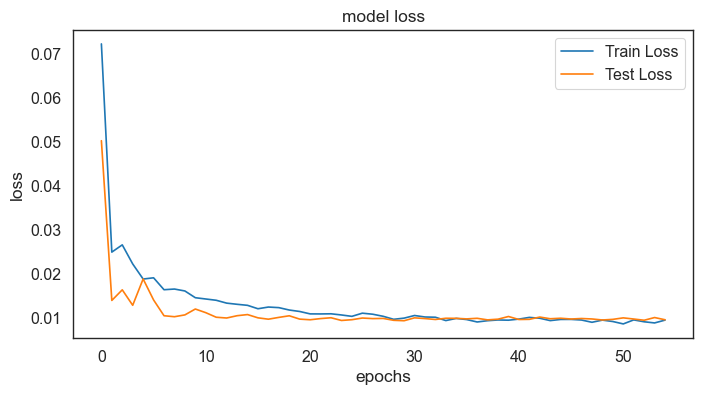

In [896]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

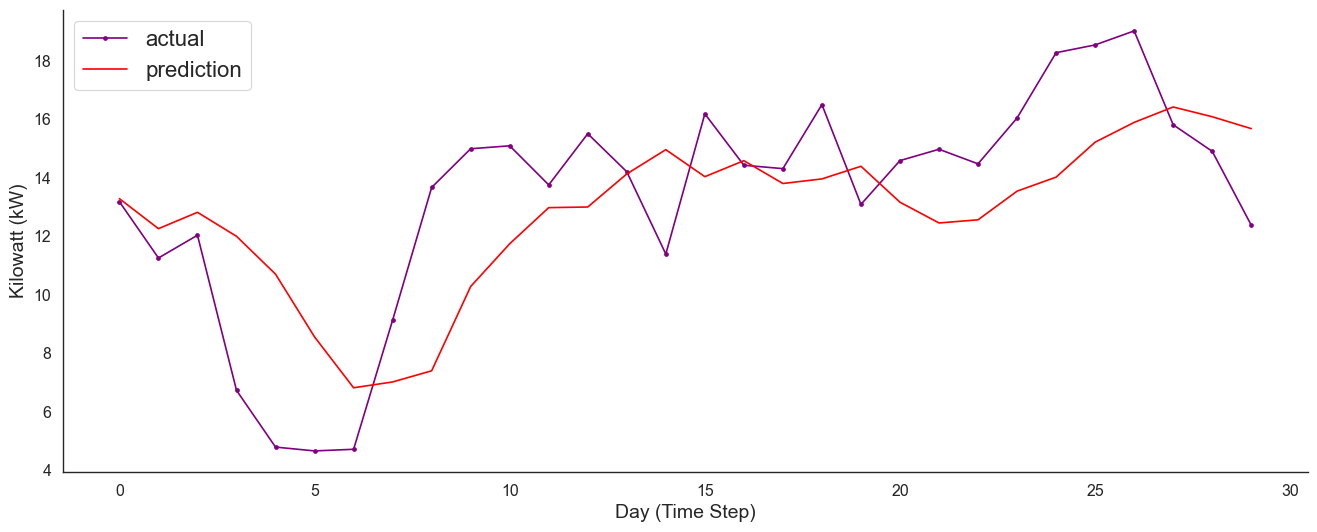

In [897]:
aa=[x for x in range(30)]
# Creating a figure object with desired figure size
#plt.rcParams.update({'font.size': 100})
                    
plt.figure(figsize=(15,6))

# Plotting the actual values in blue with a dot marker
#plt.plot(aa, Y_test[0][:30], marker='.', label="history", color='purple')

plt.plot(aa, Y_test[0][:30], marker='.', label="actual", color='purple')

# Plotting the predicted values in green with a solid line
plt.plot(aa, test_predict[:,0][:30], '-', label="prediction", color='red')

# Removing the top spines
sns.despine(top=True)

# Adjusting the subplot location
plt.subplots_adjust(left=0.07)

# Labeling the y-axis
plt.ylabel('Kilowatt (kW)', size=14)

# Labeling the x-axis
plt.xlabel('Day (Time Step)', size=14)

# Adding a legend with font size of 15
plt.legend(fontsize=16)

# Display the plot
plt.show()

In [898]:
import matplotlib.pyplot as plt1

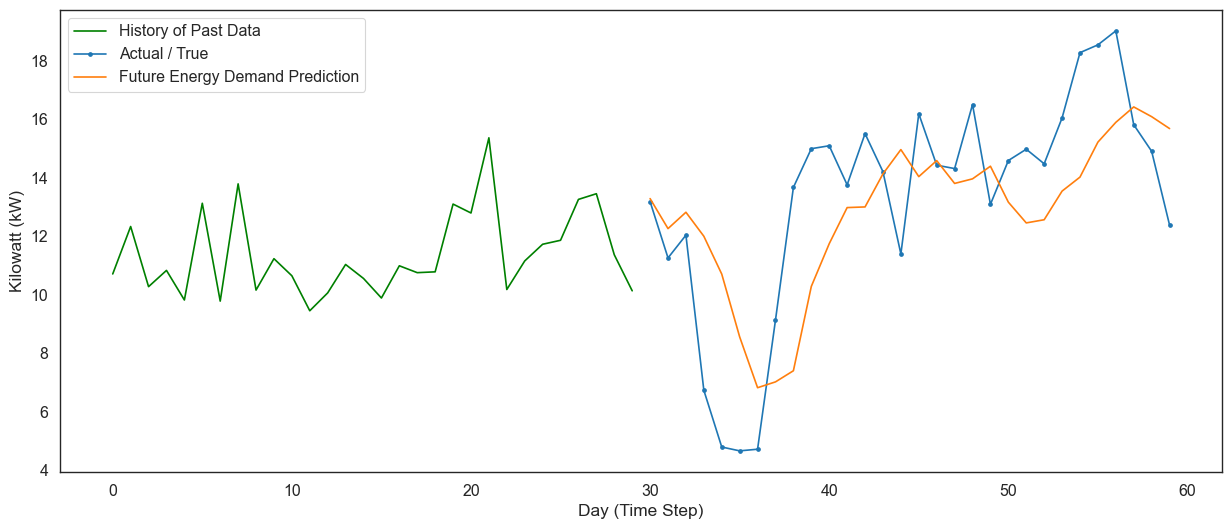

In [899]:
aa=[x for x in range(30)]
plt1.figure(figsize=(15,6))
#plt.rcParams.update({'font.size': 100})
plt1.plot(np.arange(0, len(Y_train[0][:30])), Y_train[0][:30], 'g', label="History of Past Data")
plt1.plot(np.arange(len(Y_train[0][:30]), len(Y_train[0][:30]) + len(Y_test[0][:30])), Y_test[0][:30], marker='.', label="Actual / True")
plt1.plot(np.arange(len(Y_train[0][:30]), len(Y_train[0][:30]) + len(Y_test[0][:30])), test_predict[:,0][:30], '-', label="Future Energy Demand Prediction")
plt1.ylabel('Kilowatt (kW)')
plt1.xlabel('Day (Time Step)')
plt1.legend()
plt1.show();

In [900]:
print('Shape of Label tensor: ', Y_train.shape)
print('Shape of Label tensor: ', Y_test.shape)
print('Shape of Label tensor: ', X_train.shape)
print('Shape of Label tensor: ', train_predict.shape)
print('Shape of Label tensor: ', X_test.shape)
print('Shape of Label tensor: ', test_predict.shape)

Shape of Label tensor:  (1, 373)
Shape of Label tensor:  (1, 70)
Shape of Label tensor:  (373, 1, 30)
Shape of Label tensor:  (373, 30)
Shape of Label tensor:  (70, 1, 30)
Shape of Label tensor:  (70, 30)


In [901]:
# model accuracy

#print(X_test[:2])
print(scores)


[0.009894460439682007, 0.0]


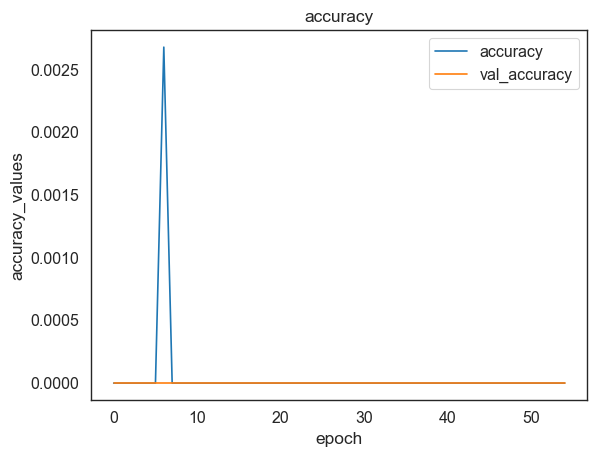

In [902]:
plt1.figure()
plt1.plot(history.history['accuracy'],label='accuracy')
plt1.plot(history.history['val_accuracy'],label='val_accuracy')
plt1.title('accuracy')
plt1.ylabel('accuracy_values')
plt1.xlabel('epoch')
plt1.legend()
plt1.show();